## 0. Libarary 불러오기 및 경로설정

In [1]:
# Baseline
from EDA import show_images, PCA
from dataset import ImageAugmentation
from dataset import MaskBaseDataset, MaskSplitByProfileDataset, TestDataset
from loss import FocalLoss, LabelSmoothingLoss, F1Loss
from train import seed_everything, k_fold_train, train, eval
from inference import test, compare_with_SOTA

import wandb

import os
from time import time
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image # tensor to pil_image
import torchvision.models as models
import torchvision.transforms as T
%matplotlib inline

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../../../../input/data/train'
images_dir = '../../../../input/data/train/images'

test_dir = '../../../../input/data/eval'
model_dir = '../../../../code/models'

In [3]:
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA: True


In [4]:
BATCH_SIZE = 70
LR = 0.0001
EPOCH = 30
NUM_WORKERS = 5

seed_everything(42)
CLASS_NUM = 18

In [5]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_csv.tail(3)

,id,gender,race,age,path
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20
2699,006959,male,Asian,19,006959_male_Asian_19


In [6]:
ds = MaskSplitByProfileDataset(images_dir, 0.2)
# ds = MaskBaseDataset(images_dir, 0.2)

# EDA

In [7]:
# ColorJitter(brightness=0~1, contrast=0~1, saturation=0~1, hue=0~1)
# GaussianBlur(kernel_size, sigma)

transform = transforms.Compose([
    T.RandomPerspective(distortion_scale=0.5, p=0.5),
    ToTensor(),
    T.ColorJitter((0.1, 0.3), 0.7, 1, (0.1, 0.3)),
    T.GaussianBlur((5,9), (0.1,0.5)),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds.set_transform(transform)

In [8]:
indexs = [7, 85, 44, 2595, 5000, 342, 234]

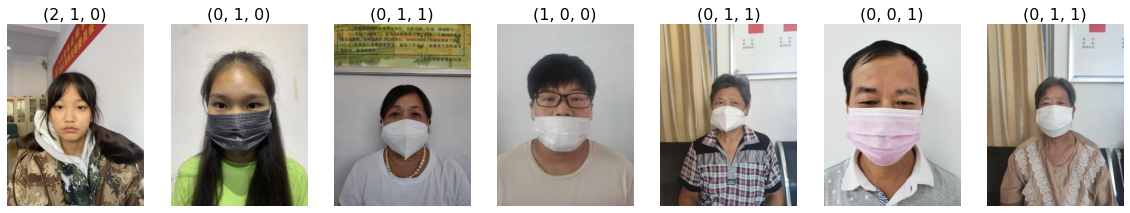

In [9]:
show_images(ds, indexs, 1, len(indexs)) # ColorJitter(0.1, 0.7, 1, 0.1)

# y class 분포 & 상관관계 확인

Counter({<MaskLabels.MASK: 0>: 13500, <MaskLabels.NORMAL: 2>: 2700, <MaskLabels.INCORRECT: 1>: 2700})
Counter({<GenderLabels.FEMALE: 1>: 11606, <GenderLabels.MALE: 0>: 7294})
Counter({<AgeLabels.YOUNG: 0>: 8967, <AgeLabels.MIDDLE: 1>: 8589, <AgeLabels.OLD: 2>: 1344})


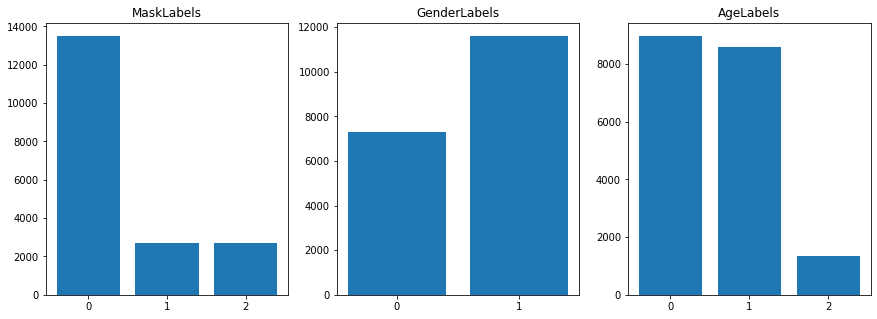

In [10]:
plt.figure(figsize=(20,5))

plot_name = ['MaskLabels', 'GenderLabels', 'AgeLabels']
for i, data in enumerate([ds.mask_labels, ds.gender_labels, ds.age_labels]):
    data = Counter(data)
    print(data)
    
    plt.subplot(1, 4, i+1)
    plt.bar(data.keys(), data.values(), tick_label=[*data.keys()])
    plt.title(plot_name[i])
plt.show()

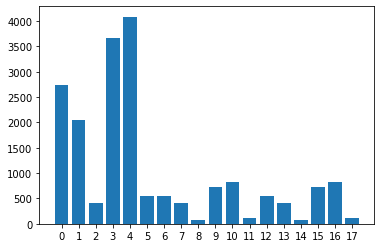

In [11]:
df_y = pd.Series([ds.encode_multi_class(mask, gender, age) for mask, gender, age in zip(ds.mask_labels, ds.gender_labels, ds.age_labels)])
df_y = df_y.value_counts()
plt.bar(df_y.index, df_y.values, tick_label=df_y.index)
plt.show()

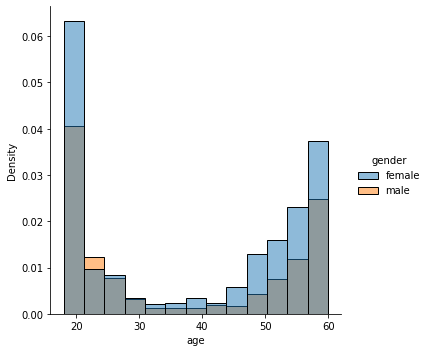

In [12]:
sns.displot(train_csv, x="age", hue="gender", stat="density")
plt.show()

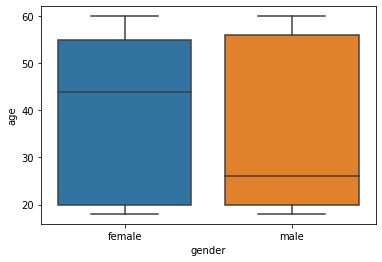

In [13]:
sns.boxplot(x='gender', y='age', data=train_csv)
plt.show()

# 얼굴 인식 Haar Cascade 방법

In [14]:
# num2class = [*ds._file_names.keys()]

In [15]:
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [16]:
# def get_ext(img_dir, img_id):
#     """
#     학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
#     Args:
#         img_dir: 학습 데이터셋 이미지 폴더 경로 
#         img_id: 학습 데이터셋 하위폴더 이름

#     Returns:
#         ext: 이미지의 확장자
#     """
#     filename = os.listdir(os.path.join(img_dir, img_id))[0]
#     ext = os.path.splitext(filename)[-1].lower()
#     return ext

In [17]:
# imgs = []
# bboxes = []
# not_found_idx = []

# img_id = train_csv.iloc[504].path
# ext = get_ext(images_dir, img_id)
# for i, class_id in enumerate(num2class):
#     img = np.array(Image.open(os.path.join(images_dir, img_id, class_id+ext)))
    
#     bbox = face_cascade.detectMultiScale(img)
#     imgs.append(img)
#     if len(bbox) != 0:
#         bboxes.append(bbox.max(axis=0))
#     else:
#         not_found_idx.append(i)
#         print(f'{class_id} not found face')
# imgs = np.array(imgs)
# bboxes = np.array(bboxes)

In [18]:
# fig, axes = plt.subplots(1, len(not_found_idx), sharex=True, sharey=True, figsize=(12, 6))
# for i, j in enumerate(not_found_idx):
#     axes[i].imshow(imgs[j])
#     axes[i].set_title(f'{num2class[j]}')
# plt.show()

## 1. Model 정의

In [20]:
# wandb setting
wandb.init(project="model test", entity="hyunah")

In [ ]:
wandb.config = {
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "epochs": EPOCH
}

In [ ]:
# train & eval dataset split
train_ss, eval_ss = ds.split_dataset()

len(train_ss), len(eval_ss)

In [ ]:
# load dataloader
train_loader = DataLoader(
    train_ss,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    shuffle=True
)
eval_loader = DataLoader(
    eval_ss,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    shuffle=True
)

len(train_loader)*BATCH_SIZE, len(eval_loader)*BATCH_SIZE

In [ ]:
# model, loss_fn, optm setting
model = models.resnet18(pretrained=True).to(device)
loss_fn = FocalLoss()
optm = torch.optim.Adam(model.parameters(), lr=LR)

# resnet dense-layer output setting
model.fc = nn.Linear(model.fc.in_features, CLASS_NUM).to(device)

# model weight init
nn.init.xavier_uniform_(model.fc.weight) # weight= Xavier init
stdv = np.sqrt(1 / model.fc.in_features)
model.fc.bias.data.uniform_(-stdv, stdv) # bias= Uniform init

In [ ]:
# import torch.nn.init as init

# def initialize_weights(model):
#     """
#     Xavier uniform 분포로 모든 weight 를 초기화합니다.
#     더 많은 weight 초기화 방법은 다음 문서에서 참고해주세요. https://pytorch.org/docs/stable/nn.init.html
#     """
#     for m in model.modules():
#         if isinstance(m, nn.Linear):
#             init.xavier_uniform_(m.weight.data)
#             if m.bias is not None:
#                 m.bias.data.zero_()

In [ ]:
# # vgg model && classifier output setting
# model = models.vgg16_bn(pretrained=True).to(device)
# model.classifier[6] = nn.Linear(in_features=4096, out_features=CLASS_NUM, bias=True).to(device)

# # model task와 our task가 유사하면, weight freeze
# model.features.requires_grad_(False) # features 파트만 freeze

# # model weight init
# initialize_weights(model.classifier)

# # loss_fn, optm setting
# loss_fn = FocalLoss()
# optm = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# model train & eval
train(train_loader, model, loss_fn, optm, EPOCH, is_wandb_logging=True)
eval(eval_loader, model)

In [ ]:
# # k-fold-cv train & eval
# k_fold_train(5, ds, model, loss_fn, loss_fn, optm, 
#              BATCH_SIZE, EPOCH, NUM_WORKERS, 
#              is_wandb_logging=True, accumulation_steps=1, patience=3)

## 2. Test Dataset 정의

## 3. Inference

In [ ]:
# torch.save(model, os.path.join(model_dir, "resnet34_crossentropy_adam.pt"))
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

In [ ]:
model_name = str(model).split('(')[0]
loss_name = str(loss_fn).split('(')[0]
optm_name = str(optm).split(' ')[0]
test_filename = f'{model_name}_{loss_name}_{optm_name}.csv'

In [ ]:
test(test_dir, model, transform, saving_filename=test_filename)

In [ ]:
compare_with_SOTA(test_dir, test_filename)

In [23]:
from inference import ensemble_hard_voting_by

ans = ensemble_hard_voting_by(test_dir, ["SOTA.csv", "ResNet_FocalLoss_Adam.csv"])

In [24]:
ans[:5]

[13, 1, 13, 13, 12]

In [25]:
info_path = os.path.join(test_dir, 'info.csv')
info = pd.read_csv(info_path)
info['ans'] = ans

info.to_csv(os.path.join(test_dir, f'output.csv'), index=False)